# Исследование поведения пользователей мобильного приложения

## Содержание 

1. [Описание проекта](#step1)
2. [Подготовка данных](#step2)
3. [Изучение и проверка данных](#step3)
4. [Изучение воронки событий](#step4)
5. [Изучение результатов эксперимента](#step5)
6. [Общий вывод](#step6)

<a id='step1'></a>
## 1. Описание проекта  

**Задачи:**  
 - Разобраться, как ведут себя пользователи мобильного приложения.  
 - Изучите воронку продаж. Узнать, как пользователи доходят до покупки. 
 - Исследовать результаты A/A/B-эксперимента и выяснить, какой шрифт лучше для приложения.
 
**Данные:**  

  Записи в логе.  
`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

[К содержанию](#Содержание)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import math
from scipy import stats as st
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (12,6)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
data = pd.read_csv('datasets/logs_exp.csv', sep='\t')

<a id='step2'></a>
## 2. Подготовка данных  

In [5]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
data = data.rename(columns = {'EventName':'event_name',
                              'DeviceIDHash':'user_id',
                             'EventTimestamp':'event_timestamp',
                              'ExpId':'exp_id'})

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['user_id'] = data['user_id'].astype('str')

In [9]:
data.duplicated().sum()

413

In [10]:
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
data['date'] = pd.to_datetime(data['event_timestamp'].dt.date,
                              format='%Y-%m-%d')

In [12]:
data.head()

,event_name,user_id,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  object        
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


**Выводы по предобработке:**  
* пропусков в данных не обнаружено
* столбец event_timestamp преобразован к типу 'datetime'
* добавлен отдельный столбец дат `date`.  
* найдено и удалено 413 строк-дубликатов.

[К содержанию](#Содержание)

<a id='step3'></a>
## 3. Изучение и проверка данных  

In [14]:
n_events = data.shape[0]
n_users = data['user_id'].nunique()
print('Всего событий: {}.'.format(n_events))
print('Всего пользователей: {}.'.format(n_users))

Всего событий: 243713.
Всего пользователей: 7551.


Выясним, сколько в среднем приходится событий на пользователя.  
Поскольку все люди разные и пользователя могут очень сильно отличаться по своему поведению, сначала посмотрим на распределение количества событий по пользователям.

In [15]:
events = data.groupby('user_id').agg({'event_name':'count'})
events = events.rename(columns={'event_name':'n_events'})

In [16]:
events.head()

,n_events
user_id,
1000608915523616548,3
100724994572555335,2
1008242126838007188,24
1009503747199967885,37
1009745980451513098,31


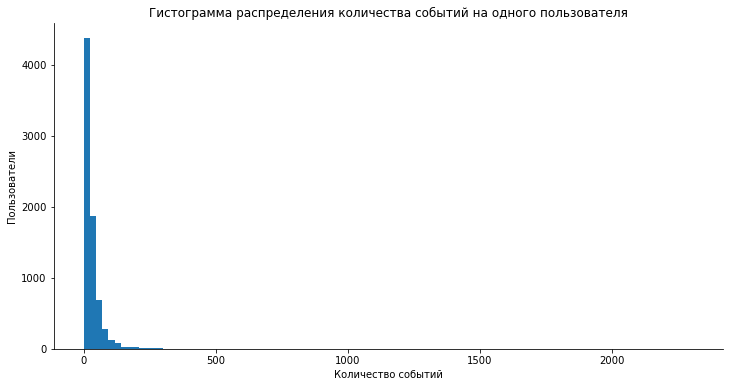

In [17]:
plt.hist(events['n_events'], bins=100)
plt.title('Гистограмма распределения количества событий на одного пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Пользователи');

Для большинства пользователей количество событий не превышает 250, однако распределение сильно скошено вправо и есть много выбросов. Для описания типичного значения количества событий больше подойдет медиана.

In [18]:
print('Медианное количество событий на одного пользователя: {}'.format(int(events.median())))

Медианное количество событий на одного пользователя: 20


Выясним, являются ли данные полными.

In [19]:
data['event_timestamp'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_timestamp, dtype: object

Доступны данные с 25 июля по 7 августа 2019 года.  
Построим гистограмму по дате и времени.  

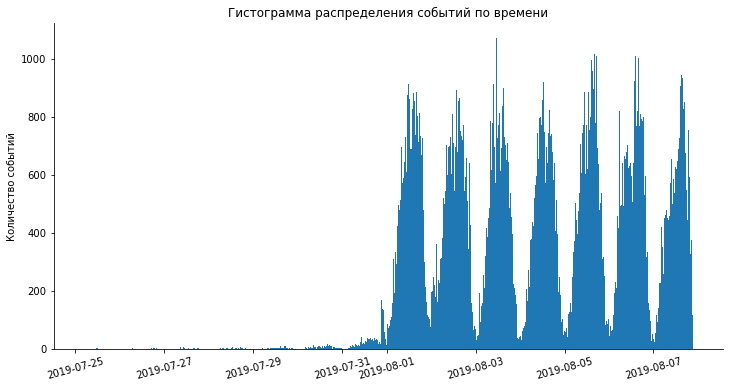

In [20]:
plt.hist(data['event_timestamp'], bins=1000)
plt.title('Гистограмма распределения событий по времени')
plt.ylabel('Количество событий')
plt.xticks(rotation=15);

По гистограмме видно, что данные до первого августа явно неполные. Исключим их из дальнейшего анализа.

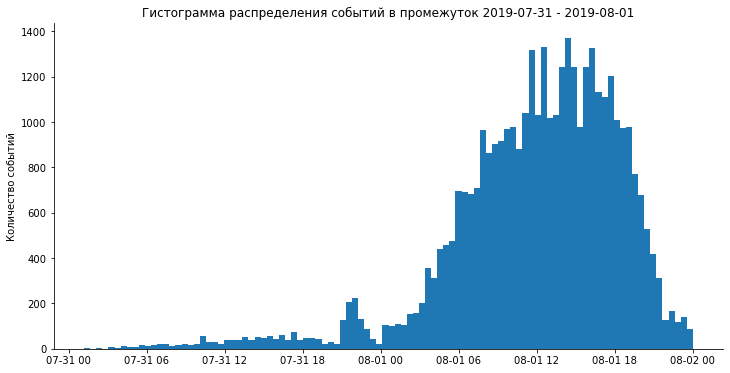

In [21]:
plt.title('Гистограмма распределения событий в промежуток 2019-07-31 - 2019-08-01')
plt.ylabel('Количество событий')
plt.hist(data[(data['date']>='2019-07-31')&(data['date']<='2019-08-01')]['event_timestamp'],
         bins=100);

Видно, что к концу дня 2019-07-31 количество событий начинает принимать значения, характерные для этого времени суток в последующие дни.  
Рассмотрим подробнее промежуток 2019-07-31 18:00:00 - 2019-08-01 00:00:00.

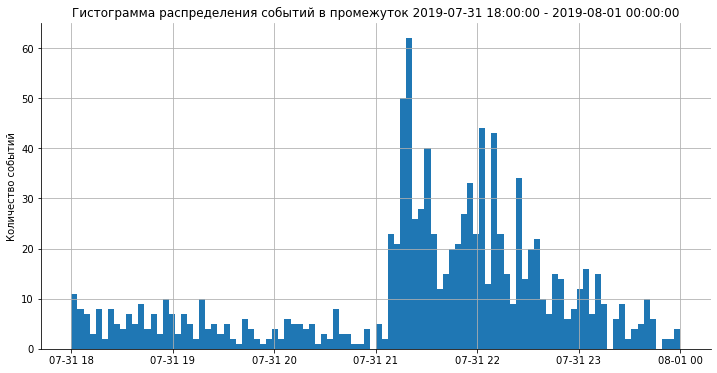

In [22]:
plt.title('Гистограмма распределения событий в промежуток 2019-07-31 18:00:00 - 2019-08-01 00:00:00')
plt.ylabel('Количество событий')
data[(data[
    'event_timestamp']<='2019-08-01 00:00:00')&(data['event_timestamp']>='2019-07-31 18:00:00')][
    'event_timestamp'].hist(bins=100);

Количество событий начинает принимать характерные значения около 21:00 31 июля. Судя по всему, это время начала теста.  

In [23]:
data = data[data['event_timestamp']>='2019-07-31 21:00:00']

In [24]:
print('Всего событий после удаления неполных данных: {}.'.format(data.shape[0]))
print('Всего пользователей после удаления неполных данных: {}.'.format(data['user_id'].nunique()))

Всего событий после удаления неполных данных: 241724.
Всего пользователей после удаления неполных данных: 7538.


Выясним, много ли событий мы потеряли.

In [25]:
n_events_lost = n_events - data.shape[0]
pct_events_lost = 1 - data.shape[0]/n_events
print('В результате удаления неполных данных потеряна информация о {} событиях, что составляет \
{:.2%} от первоначального числа.'.format(n_events_lost, pct_events_lost))

В результате удаления неполных данных потеряна информация о 1989 событиях, что составляет 0.82% от первоначального числа.


In [26]:
n_users_lost = n_users - data['user_id'].nunique()
pct_users_lost = 1 - data['user_id'].nunique()/n_users
print('В результате удаления неполных данных потеряна информация о {} пользователях, что составляет \
{:.2%} от первоначального числа.'.format(n_users_lost, pct_users_lost))

В результате удаления неполных данных потеряна информация о 13 пользователях, что составляет 0.17% от первоначального числа.


Количество отброшенных данных несущественно: 0.82% событий и 0.17% пользователей.  
Убедимся, что у нас есть пользователи из всех трех экспериментальных групп.  

In [27]:
data.groupby('exp_id').agg({'user_id':'nunique'})

,user_id
exp_id,
246,2484
247,2517
248,2537


**Выводы по проверке данных:**  
* Изначально были доступны данные по 243713 событиям, совершенным 7551 пользователем.  
* Распределение количества событий по пользователям сильно скошено вправо и имеет выбросы.  
* Медианное количество событий на пользователя - 20.  
* Выяснилось, что данные до 21:00 31 июля неполные и они были отброшены, в результате чего потеряны данные по 0.82% событий и 0.17% пользователей.  
* В оставшихся данных имеются пользователи из всех трех экспериментальных групп.  


[К содержанию](#Содержание)

<a id='step1'></a>
## 4. Изучение воронки событий  

Посмотрим, какие события есть в логах и как часто они встречаются.  

In [28]:
events = data.groupby('event_name', as_index=False).agg({'user_id':'count'})
events = events.rename(columns={'user_id':'n_events'})
events.sort_values('n_events', ascending=False)

,event_name,n_events
1,MainScreenAppear,117889
2,OffersScreenAppear,46531
0,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


Самое часто встречающееся событие - просмотр главной страницы. Самое редкое событие - просмотр страницы с обучением. Либо пользователям и так все понятно, либо  возможность перехода на страницу с обучением не очевидна.  

Посчитаем, сколько пользователей совершали то или иное событие.

In [29]:
events_by_users = data.groupby('event_name', as_index=False).agg({'user_id':'nunique'})
events_by_users = events_by_users.rename(columns={'user_id':'n_users'})
events_by_users['users_share'] = events_by_users['n_users']/data['user_id'].nunique()
events_by_users.sort_values('n_users', ascending=False)

,event_name,n_users,users_share
1,MainScreenAppear,7423,0.984744
2,OffersScreenAppear,4597,0.609843
0,CartScreenAppear,3736,0.495622
3,PaymentScreenSuccessful,3540,0.469621
4,Tutorial,843,0.111833


Почти все пользователи видят главную страницу приложения. Только половина пользователей доходят до корзины, причем примерно 2.5% не удается завершить заказ.

Предполагаю, что события должны происходить в следующем порядке:  
Просмотр главной страницы (MainScreenAppear) → Обучение (Tutorial) → Просмотр страницы с предолжениями (OffersScreenAppear) → Просмотр корзины (CartScreenAppear) → Сообщение об успешной оплате (PaymentScreenSuccessful).
Видимо, обучение является опциональным, и его не нужно учитывать при расчете воронки.  

Посчитаем, какая доля пользователей переходит на следующий шаг воронки. 

In [30]:
funnel = events_by_users[events_by_users[
    'event_name'] != 'Tutorial'][['event_name', 'n_users']].sort_values('n_users', ascending=False)
funnel['pct_change'] = funnel['n_users'].pct_change()
funnel

,event_name,n_users,pct_change
1,MainScreenAppear,7423,NaN
2,OffersScreenAppear,4597,-0.380709
0,CartScreenAppear,3736,-0.187296
3,PaymentScreenSuccessful,3540,-0.052463


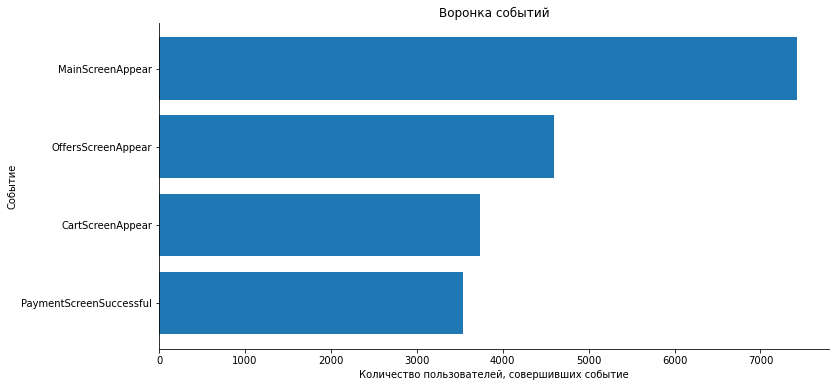

In [31]:
plt.barh(funnel.sort_values('n_users')['event_name'], funnel.sort_values('n_users')['n_users'])
plt.title('Воронка событий')
plt.ylabel('Событие')
plt.xlabel('Количество пользователей, совершивших событие');

Видно, что больше всего пользователей теряется при переходе от главной страницы к странице с товарами.  
Рассчитаем долю пользователей, которые доходят от первого события до оплаты:

In [32]:
print(f'{funnel.iloc[3,1]/funnel.iloc[0,1]:.2%}')

47.69%


**Выводы по анализу воронки событий:**
* Выявлена проблема с главной страницей приложения. Очень немногие пользователи находят страницу с обучением, более того почти 40% пользователей не находят страницу с товарами.  
* От первого шага до оплаты доходят только около 48 процентов пользователей.  

[К содержанию](#Содержание)

<a id='step1'></a>
## 5. Изучение результатов эксперимента  

246, 247 - контрольные группы  
248 - экспериментальная группа  
Посмотрим, сколько пользователей в каждой экспериментальной группе (включая объединенную экспериментальную группу):

In [33]:
groups = data.groupby('exp_id').agg({'user_id':'nunique'})
groups.loc['combined'] = groups.loc[246] + groups.loc[247]
groups

,user_id
exp_id,
246,2484
247,2517
248,2537
combined,5001


In [34]:
n_246 = int(groups.loc[246])
n_247 = int(groups.loc[247])
n_248 = int(groups.loc[248])

Видно, что группы немного отличаются по количеству. Посмотрим на относительное различие между группами в процентах.

In [35]:
print('Относительное различие в количестве между первой экспериментальной \
и контрольной группой: {:.2%}'.format((n_248/n_246) - 1))

Относительное различие в количестве между первой экспериментальной и контрольной группой: 2.13%


In [36]:
print('Относительное различие в количестве между второй экспериментальной \
и контрольной группой: {:.2%}'.format((n_248/n_247) - 1))

Относительное различие в количестве между второй экспериментальной и контрольной группой: 0.79%


In [37]:
print('Относительное различие в количестве между контрольными группами: {:.2%}'.format(
    (n_247/n_246) - 1))

Относительное различие в количестве между контрольными группами: 1.33%


Проверим, нет ли пользователей, попавших одновременно в разные группы.

In [38]:
users_246 = data[data['exp_id']==246]['user_id'].unique()
users_247 = data[data['exp_id']==247]['user_id'].unique()
users_248 = data[data['exp_id']==248]['user_id'].unique()

In [39]:
sum([(user_a in users_248) for user_a in users_246])

0

In [40]:
sum([(user_a in users_248) for user_a in users_247])

0

In [41]:
sum([(user_a in users_246) for user_a in users_247])

0

Каждый пользователь попал только в одну группу. 

Проверим, находят ли статистические критерии разницу между контрольными выборками 246 и 247.

Посчитаем количество и долю пользователей, совершивших определенное событие в каждой из контрольных групп.

In [42]:
def num_events_in_group(group):
    if group=='combined':
        df = data[(data['exp_id']==246)|(data['exp_id']==247)]
    else:
        df = data[data['exp_id']==group]
    events_by_users = df.groupby('event_name', as_index=False).agg({'user_id':'nunique'})
    events_by_users = events_by_users.rename(columns={'user_id':'n_users'})
    events_by_users['users_share'] = events_by_users['n_users']/df['user_id'].nunique()
    return events_by_users.sort_values('n_users', ascending=False)

In [43]:
events_246 = num_events_in_group(246)
events_246

,event_name,n_users,users_share
1,MainScreenAppear,2450,0.986312
2,OffersScreenAppear,1542,0.620773
0,CartScreenAppear,1266,0.509662
3,PaymentScreenSuccessful,1200,0.483092
4,Tutorial,278,0.111916


In [44]:
events_247 = num_events_in_group(247)
events_247

,event_name,n_users,users_share
1,MainScreenAppear,2479,0.984903
2,OffersScreenAppear,1524,0.605483
0,CartScreenAppear,1239,0.492253
3,PaymentScreenSuccessful,1158,0.460072
4,Tutorial,284,0.112833


In [45]:
events_combined = num_events_in_group('combined')
events_combined

,event_name,n_users,users_share
1,MainScreenAppear,4929,0.985603
2,OffersScreenAppear,3066,0.613077
0,CartScreenAppear,2505,0.500900
3,PaymentScreenSuccessful,2358,0.471506
4,Tutorial,562,0.112378


Проверим, являются ли разности в долях пользователей, совершивших определенное событие в разных контрольных группах статистически значимыми. Уровень значимости $\alpha$ примем равным 0.05.

In [46]:
alpha = 0.05

Поскольку мы будем сравнивать доли пользователей, совершивших каждое из пяти событий между группами 246-247, 246-248, 247-248 и объединенной контрольной и 248 на одних и тех же данных, необходимо скорректировать уровень значимости. Всего получается $5*4=20$ проверок. Воспользуемся методом Бонферрони. 

In [47]:
alpha_corrected = alpha/20

In [48]:
def stat_check(group_a, group_b, alpha):
    for event in data['event_name'].unique():
        data_a = num_events_in_group(group_a)
        data_b = num_events_in_group(group_b)
        p1 = float(data_a.loc[data_a['event_name']==event, 'users_share'])
        p2 = float(data_b.loc[data_b['event_name']==event, 'users_share'])
        p_combined = (int(data_a.loc[data_a['event_name']==event, 'n_users']) + \
                   int(data_b.loc[data_b['event_name']==event, 'n_users']))/\
                   (int(groups.loc[group_a]) + int(groups.loc[group_b]))
        difference = p1 - p2
        z_value = difference/(math.sqrt(p_combined*(1-p_combined)*((1/int(groups.loc[group_a]))+(
        1/int(groups.loc[group_b])))))
        distr = st.norm(0,1)
        p_value = (1 - distr.cdf(abs(z_value)))*2
        print('Гипотеза H0: доли пользователей, совершивших событие {} в группах {} и {} не различаются'
          .format(event, group_a, group_b))
        print('Гипотеза H1: доли пользователей, совершивших событие {} в группах {} и {} различаются'
          .format(event, group_a, group_b))
        print('p-значение: {:.3f}'.format(p_value))
        if p_value<alpha:
            print('Отвергаем H0.')
        else:
            print('Не отвергаем H0.')
            print()

In [49]:
stat_check(246, 247, alpha_corrected)

Гипотеза H0: доли пользователей, совершивших событие MainScreenAppear в группах 246 и 247 не различаются
Гипотеза H1: доли пользователей, совершивших событие MainScreenAppear в группах 246 и 247 различаются
p-значение: 0.676
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие OffersScreenAppear в группах 246 и 247 не различаются
Гипотеза H1: доли пользователей, совершивших событие OffersScreenAppear в группах 246 и 247 различаются
p-значение: 0.267
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие PaymentScreenSuccessful в группах 246 и 247 не различаются
Гипотеза H1: доли пользователей, совершивших событие PaymentScreenSuccessful в группах 246 и 247 различаются
p-значение: 0.103
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие CartScreenAppear в группах 246 и 247 не различаются
Гипотеза H1: доли пользователей, совершивших событие CartScreenAppear в группах 246 и 247 различаются
p-значение: 0.218
Не отвергаем H0.

Гипотеза H

Статистически значимого различия между долями пользователей в двух контрольных группах не обнаружено. Разбиение на группы работает корректно.  
Сравним результаты каждой из контрольных групп с группой с измененным шрифтом.  

In [50]:
# Сравниваем с первой контрольной группой:
stat_check(246, 248, alpha_corrected)

Гипотеза H0: доли пользователей, совершивших событие MainScreenAppear в группах 246 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие MainScreenAppear в группах 246 и 248 различаются
p-значение: 0.347
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие OffersScreenAppear в группах 246 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие OffersScreenAppear в группах 246 и 248 различаются
p-значение: 0.208
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие PaymentScreenSuccessful в группах 246 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие PaymentScreenSuccessful в группах 246 и 248 различаются
p-значение: 0.223
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие CartScreenAppear в группах 246 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие CartScreenAppear в группах 246 и 248 различаются
p-значение: 0.083
Не отвергаем H0.

Гипотеза H

In [51]:
# Сравниваем со второй контрольной группой:
stat_check(247, 248, alpha_corrected)

Гипотеза H0: доли пользователей, совершивших событие MainScreenAppear в группах 247 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие MainScreenAppear в группах 247 и 248 различаются
p-значение: 0.600
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие OffersScreenAppear в группах 247 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие OffersScreenAppear в группах 247 и 248 различаются
p-значение: 0.884
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие PaymentScreenSuccessful в группах 247 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие PaymentScreenSuccessful в группах 247 и 248 различаются
p-значение: 0.678
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие CartScreenAppear в группах 247 и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие CartScreenAppear в группах 247 и 248 различаются
p-значение: 0.617
Не отвергаем H0.

Гипотеза H

Сравним результаты с объединенной контрольной группой.

In [52]:
stat_check('combined', 248, alpha_corrected)

Гипотеза H0: доли пользователей, совершивших событие MainScreenAppear в группах combined и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие MainScreenAppear в группах combined и 248 различаются
p-значение: 0.393
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие OffersScreenAppear в группах combined и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие OffersScreenAppear в группах combined и 248 различаются
p-значение: 0.419
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие PaymentScreenSuccessful в группах combined и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие PaymentScreenSuccessful в группах combined и 248 различаются
p-значение: 0.645
Не отвергаем H0.

Гипотеза H0: доли пользователей, совершивших событие CartScreenAppear в группах combined и 248 не различаются
Гипотеза H1: доли пользователей, совершивших событие CartScreenAppear в группах combined и 248 различаются
p-знач

**Вывод:**  
Статистически значимой разницы между долями пользователей, совершивших то или иное событие в группах со старым шрифтом и новым шрифтом не выявлено. 

[К содержанию](#Содержание)

<a id='step1'></a>
## 6. Общий вывод  
* Изначально были доступны данные по 243713 событиям, совершенным 7551 пользователями. В ходе проверки выяснилось, что данные до 21:00 31 июля 2019 года неполные, и они были исключены из дальнейшего анализа. Потери незначительны: исключены 0.82% событий и 0.77% пользователей.  
* Анализ воронки событий выявил следующие проблемы:
 * только 48% пользователей доходят от просмотра главной страницы до оплаты,  
 * 38% пользователей, оказавшихся на главной странице, не переходят на страницу с товарами,  
 * страницу с обучением используют только 11%.  
 Следовательно, необходимо детально изучить главную страницу, и понять, в чем может быть проблема.  
* Изучение результатов экспериметна показало, что нет оснований считать, что изменение шрифта в приложении влияет на долю пользователей, совершающих то или иное событие. Значит, шрифт можно изменить.  

[К содержанию](#Содержание)